# Consuming from topic "data"
In this section we will create the first consumer.

This consumer will compared between two methods of clustering:
Kmeans and Bisecting Kmeans.

In [6]:
# Import libraries
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import adjusted_rand_score
from pyspark.ml.feature import StandardScaler, IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.clustering import KMeans,BisectingKMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [7]:
from confluent_kafka import Consumer, KafkaError, KafkaException

# creating the consumer
c = Consumer({'bootstrap.servers': "localhost:9092",
              'group.id': "foo",
              'auto.offset.reset': 'earliest'})

In [8]:
# create function that adds from "data" topic to dictionary
def update_d(d, customer):
    # function to update data dict
    temp = json.loads(customer.decode('utf-8'))
    for key, val in temp.items():
        d[key] = val

In [9]:
# create a function that receives a dictionary and tranforms it to a pyspark df
def dict_to_spark_df(d):
    # get column names
    cols = d['0'] 
    # create pandas df from dictionary
    df = pd.DataFrame.from_dict(d) 
    df = df.T 
    df.columns = cols
    df = df.iloc[1:, :]
    # label encoding the target column "custcat"
    le = preprocessing.LabelEncoder()
    df['price_range'] = le.fit_transform(df['price_range'].values)
    # cast df to integer
    df = df.astype('float')
    # send to pyspark
    sparkDF = spark.createDataFrame(df)
    return (sparkDF, cols[0:-2])

In [10]:
# create a function that prepares the df for the clustering algorithms
def prepare_data(data, cols):
    #assemble acolumn of features for the clustering algorithms
    assemble = VectorAssembler(inputCols=cols, outputCol='features')
    assembled_data = assemble.transform(data)
    # standartize data
    scale = StandardScaler(inputCol='features',outputCol='standardized')
    data_scale = scale.fit(assembled_data)
    data_scale_output = data_scale.transform(assembled_data)
    return(data_scale_output)

In [11]:
# create a function that plots the time calculation and accuracy graphs
def PlotResultsFunc(time1, time2, acc1, acc2, title1, title2):
    x_ax = np.arange(len(time1))
    # Plot accuracy 
    plt.figure(figsize = (12,7))
    plt.plot(x_ax, acc1, label = title1)
    plt.plot(x_ax, acc2, label = title2)
    plt.legend()
    plt.title('Accuracy comparison',fontsize=18)
    plt.xlabel('Consumer Iteration',fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()
    # Plot processing time
    plt.figure(figsize = (12,7))
    plt.plot(x_ax, time1, label = title1)
    plt.plot(x_ax, time2, label = title2)
    plt.legend()
    plt.title('Time comparison',fontsize=18)
    plt.xlabel('Consumer Iteration',fontsize=14)
    plt.ylabel('Time [s]', fontsize=14)
    plt.show()

In [12]:
def CreateModel(data, model_val, time_lst, acc_lst, model_name):
    start_time = time.time()
    model = model_val.fit(data)
    end_time = time.time()
    time_lst.append(end_time - start_time)              
    # "predictions" is a pyspark DF containing the input DF + a column called prediction
    predictions = model.transform(data)
    predictions.select('price_range', 'prediction').show(5)
    pred = np.array(predictions.select('prediction').rdd.flatMap(lambda x: x).collect())
    cat = predictions.select('price_range').rdd.flatMap(lambda x: x).collect()
    acc_lst.append(adjusted_rand_score(cat,pred))
    print("acc of "+str(model_name) +str(acc_lst[-1]))
    return time_lst, acc_lst
    
    

In [13]:
# create function to consume and process the data from the topics
def infinite_consumer(c, topics):
    try:
        c.subscribe(topics)
        # create a dictionary were we keep the data
        d = {}
        counter = 0
        #create 2 lists for timing each clustering algorithm as they fit the model
        time1=[]
        time2=[]        
        #create 2 lists for accuracy of each clustering algorithm as they fit the model
        acc1=[]
        acc2=[]        
        while True:
            # consume from topics with time-out of 5 seconds
            messages = c.consume(timeout=5) 
            # read messages from topics
            for msg in messages:
                counter = counter+1
                print(counter)
                # check if no errors or nones
                if msg is None: continue
                if msg.error():
                    if msg.error().code() == KafkaError._PARTITION_EOF:
                        # End of partition event
                        sys.stderr.write('%% %s [%d] reached end at offset %d\n' %(msg.topic(), msg.partition(), msg.offset()))
                    elif msg.error():
                        raise KafkaException(msg.error())
                # if there are no errors we can use the messages for our task
                elif msg.topic() == 'data':
                    # add data logs to our dictionary
                    update_d(d, msg.value())
                    print(next(iter((d.items()))))
                    # send content of dictionary to spark dataframe
                    data, cols = dict_to_spark_df(d)
                    # prepare data for clustering algorithms
                    data = prepare_data(data, cols)
                    
                    # K-means
                    kmeans_val = KMeans(k=4, seed=42)
                    time1, acc1 = CreateModel(data, kmeans_val, time1, acc1, 'Kmeans')

                    # Bisecting K-means
                    Bkmeans_val = BisectingKMeans(k=4, seed=42)
                    time2, acc2 = CreateModel(data, Bkmeans_val, time2, acc2, 'Bisecting Kmeans')              
                    
            if counter==20:
                PlotResultsFunc(time1, time2, acc1, acc2,"Kmeans","Bisecting Kmeans")
                counter = 0
    finally:
        # close consumer
        c.close()


1
('0', ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range'])
23/02/07 21:18:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+----------+
|price_range|prediction|
+-----------+----------+
|        1.0|         1|
|        2.0|         2|
|        2.0|         2|
|        2.0|         2|
|        1.0|         3|
+-----------+----------+
only showing top 5 rows

acc of Kmeans0.3917900305220851
+-----------+----------+
|price_range|prediction|
+-----------+----------+
|        1.0|         2|
|        2.0|         3|
|        2.0|         3|
|        2.0|         3|
|        1.0|         1|
+-----------+----------+
only showing top 5 rows

acc of Bisecting Kmeans0.4530592931675267
2
('0', ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range'])
+-----------+----------+
|price_range|prediction|
+-----------+----------+
|        1.0|         0|
|        2.0|         1|
|        2.0|         1|
|        2.0|         1|
|        

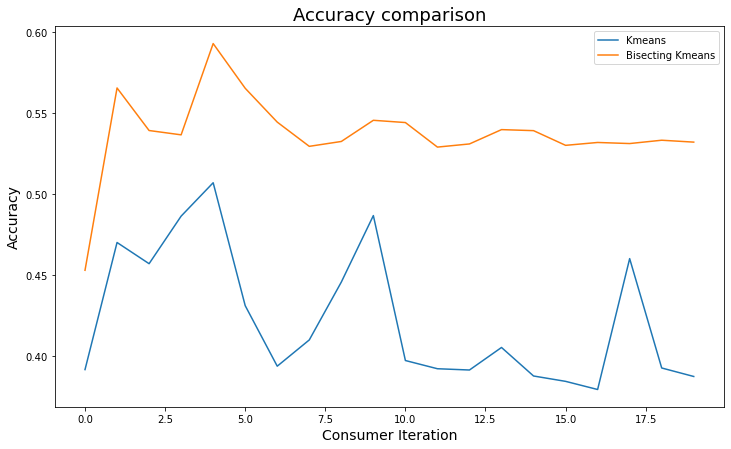

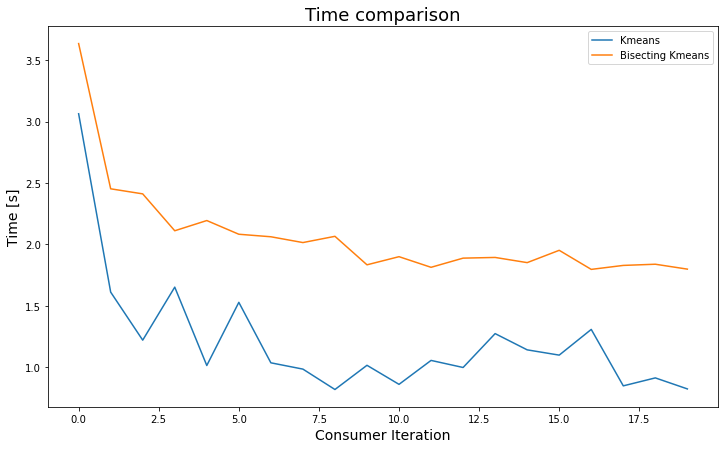

In [ ]:
infinite_consumer(c, ['data'])